# 課題６
1810083 井上悠香
## 1. Pytorchのチュートリアル
### 1.1 Tensor
torch.tensorは、基本的にnumpyのようなもの。GPU上で計算を加速するために使用できる。相互変換可能。（Numpyブリッジ）　Torch TensorとNumpy配列は（Torch TensorがCPU上にある場合）メモリ位置を共有する。従って**一方の変更は他方を変更する。**<br>
属性 .requires_gradをTrueにすることで全ての演算を追跡し始める。自動微分を行うフラグが有効になる。演算を積み重ねることで計算グラフが構築されていき、backwardを呼ぶとその情報から自動的に微分を計算できる。


参考:https://codezine.jp/article/detail/11052<br>
https://torch.classcat.com/2020/04/27/pytorch-1-5-tutorials-learning-autograd/

In [1]:
import torch
#numpyとtorch.tnsorの相互変換
x = torch.ones(5)
print("x: ",x)
y = x.numpy()
print("y: ",y)

#変換した後一方を変更するともう一方も変更する
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)#tensorに変換
np.add(a,1,out = a)#aに1をたす
print("a: ",a)
print("b: ",b)#aに1を足した処理がbにも反映されている

x:  tensor([1., 1., 1., 1., 1.])
y:  [1. 1. 1. 1. 1.]
a:  [2. 2. 2. 2. 2.]
b:  tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


In [4]:
#Autograd 自動微分
import torch
x = torch.ones(2,2,requires_grad=True) #追跡する
print(x)
y = x+2#tensor演算
print(y)#演算の結果として作成されたのでyはgrad_fnを持っている
z = y*y*3#yについてさらに演算
out = z.mean()#テンソルのすべての要素の平均値を返す→27
print(z,out)


a = torch.randn(2,2)#デフォルトはrequires_grad=Falseなので追跡していない。
a = ((a*3)/(a-1))
print("a.requires_grad : ",a.requires_grad)
a.requires_grad_(True)#追跡する
print("a.requires_grad : ",a.requires_grad)
b = (a*a).sum()
print("a.requires_grad : ",b.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
a.requires_grad :  False
a.requires_grad :  True
a.requires_grad :  <SumBackward0 object at 0x7f2d5e529eb8>


In [5]:
#勾配を求める
#一般的に言えばtorch.autogradはベクトルとヤコビアンの積を計算するためのエンジン。
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [7]:
v = torch.tensor([0.1,1.0,0.0001],dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [8]:
#with torch.no_grad(): コードブロックをラッピングすることにより追跡を止められる
print(x.requires_grad)
print((x**2).requires_grad)

with torch.no_grad():
  print((x**2).requires_grad)

True
True
False


In [9]:
#ちょっと使い方よくわからなかった。detach() 勾配を必要としない新しいTensorを得るときに使える？
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


### 1.2 ニューラルネットワーク

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #imput image channel 1、output channels 6、3x3の畳み込み
    #カーネル　（フィルター）
    self.conv1 = nn.Conv2d(1,6,3)
    self.conv2 = nn.Conv2d(6,16,3)

    #アフィンレイヤ　線形変換　隠れ層の定義
    self.fc1 = nn.Linear(16*6*6,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

    #backward関数はautogradを使って自動定義される
    def forward(self,x):
      #プーリング　2x2領域から最大値を探す
      x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
      x = F.max_pool2d(F.relu(self.conv2(x)),2)
      x = F.view(-1,self.num_flat_feature(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x
    
    def num_flat_features(self,x):
      size = x.size()[1:]
      num_features = 1
      for s in size:
        num_features *= s
      return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [30]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #imput image channel 1、output channels 6、5x5畳み込み
        #カーネル　（フィルター）
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
       #プーリング　2x2領域から最大値を探す
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [31]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) 

10
torch.Size([6, 1, 5, 5])


In [32]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0565, -0.0981, -0.0388,  0.0606,  0.0271, -0.0278,  0.0799, -0.0624,
         -0.0325, -0.0249]], grad_fn=<AddmmBackward>)


In [33]:
net.zero_grad()
out.backward(torch.randn(1, 10))

#### クラスのまとめ
- **torch.Module** : ニューラルネットワークのモジュール。GPUにエクスポートするためのヘルパーを持つ
- **torch.Parameter** : Tensorの一種。自動的に登録される
- **torch.Function** : 

## 1.3 分類器を訓練する – CIFAR-10
ステップ
1.  CIFAR10 訓練とテスト・データセットを torchvision を使用してロードして正規化
1.  畳込みニューラルネットワークを定義
1.  損失関数を定義
1.  訓練データ上でネットワークを訓練
1.  テストデータ上でネットワークをテスト

#### CIFER-10とは
32x32ピクセルのカラー画像、RGBの3チャンネルあり。十種類のクラスに分類されている。

参考 : [【PyTorchチュートリアル④】TRAINING A CLASSIFIER](https://qiita.com/sudominoru/items/61f57946799e67cedd47)

In [11]:
#CIFER-10の読み込みと正規化
import torch
import torchvision#CIFER10のロードに使う
import torchvision.transforms as transforms

#テンソルに変換して標準化→RGB値を[-1,1]に変換している。
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
 #訓練データのロード
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)
 #テストデータのロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)
 #クラスの定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


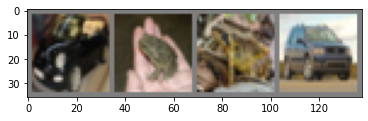

  car  frog  frog   car


In [12]:
#画像を表示してみる
import matplotlib.pyplot as plt
import numpy as np
 
 #画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5     #標準化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
 
 
# 訓練用データからランダムに画像を取得する
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# 画像を表示
imshow(torchvision.utils.make_grid(images))
# ラベルを表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
#ニューラルネットワークを3チャンネル画像が得られるように変更する
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [14]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  #何周するか

    running_loss = 0.0
     #入力情報
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # 勾配を初期化
        optimizer.zero_grad()

        outputs = net(inputs)
        # 誤差の計算
        loss = criterion(outputs, labels)
        # 逆伝播の計算
        loss.backward()
        # 重みの計算
        optimizer.step()

        # 2000ごとに状態を表示する
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2,000 データずつ
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.176
[1,  4000] loss: 1.809
[1,  6000] loss: 1.652
[1,  8000] loss: 1.537
[1, 10000] loss: 1.462
[1, 12000] loss: 1.408
[2,  2000] loss: 1.346
[2,  4000] loss: 1.335
[2,  6000] loss: 1.314
[2,  8000] loss: 1.287
[2, 10000] loss: 1.289
[2, 12000] loss: 1.246
Finished Training


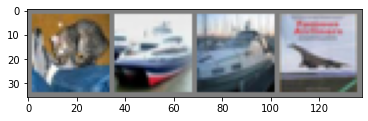

教師データ:    cat  ship  ship plane
tensor([-1.7400, -2.3955,  0.6639,  3.2348, -1.0701,  2.7824,  3.3754, -1.8461,
        -2.1709, -1.5751], grad_fn=<SliceBackward>)
Predicted:   frog  ship  ship  ship


In [15]:
#テストデータ1つ表示してみる
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('教師データ: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
print(outputs[0,:])

_, predicted = torch.max(outputs, 1)
 
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [16]:
#全体の精度
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images,labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' %(100*correct/total))

Accuracy of the network on the 10000 test images: 56 %


In [17]:
#クラスごとの認識精度
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 51 %
Accuracy of  bird : 30 %
Accuracy of   cat : 41 %
Accuracy of  deer : 47 %
Accuracy of   dog : 47 %
Accuracy of  frog : 76 %
Accuracy of horse : 55 %
Accuracy of  ship : 73 %
Accuracy of truck : 72 %


In [18]:
# GPU上での学習
#GPUを使っているかの確認
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

#gpuに転送
net.to(device)

inputs, labels = inputs.to(device), labels.to(device)

cuda:0


# チュートリアルについての感想
精度は低いものの、画像についてちゃんと学習していることがわかった。やっていること自体は、前回までに学習したニューラルネットワークの実装そのものだが、PyTorchを使うと、データのロードと逆伝播を実装する必要がなくて楽というのは伝わった。
認識精度が低いのは、多分epochが２で周回数が少ないためと考えている。GPUを使って計算してもそこまで実行時間は変わらなかった。しかし、下の追加課題の方ではGPUの方がかなり早く感じたので、これは今回のepochが２でネットワークが小さいからであったからと考えられる。正直やっていることはわかるけど自分で実装しろと言われたら絶対できないと感じている。前回までのニューラルネットワークも復習していきたい。

## 2.追加課題　CBOWモデルの学習と評価

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/Colab Notebooks/kobo2020'
%ls

/content/gdrive/My Drive/Colab Notebooks/kobo2020
cbow_params.pkl  common/                     __pycache__/
cbow.py          dataset/                    PyTorchTutorial1.ipynb
ch04/            negative_sampling_layer.py  Untitled0.ipynb


In [ ]:
%cd '/content/drive/'
%ls

[Errno 2] No such file or directory: '/content/drive/'
/content
gdrive/  sample_data/


In [ ]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   7348      0 --:--:-- --:--:-- --:--:--  7348
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 339.6MB 18kB/s 
+ set +ex
Installation succeeded!


| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 0[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.04
| epoch 1 |  iter 101 / 9295 | time 1[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 1[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 1[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 2[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 2[s] | loss 3.39
| epoch 1 |  iter 201 / 9295 | time 2[s] | loss 3.28
| epoch 1 |  iter 221 / 9295 | time 3[s] | loss 3.16
| epoch 1 |  iter 241 / 9295 | time 3[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 3[s] | loss 3.04
| epoch 1 |  iter 281 / 9295 | time 3[s] | loss 2.96
| epoch 1 |  iter 301 / 9295 | time 4[s] | loss 2.92
| epoch 1 |  iter 321 / 9295 | time 4[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 4[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 5[s] | loss 2.83

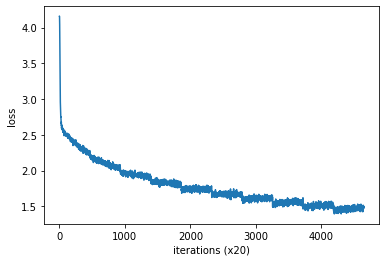

In [ ]:
#4.2.1　CBOWモデルの学習コード
import sys
sys.path.append(' . . ')
import numpy as np
from common import config
config.GPU = True
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target,to_cpu,to_gpu
from dataset import ptb

#ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

#データの読み込み
corpus,word_to_id,id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
contexts,target = create_contexts_target(corpus,window_size)
if config.GPU:
  contexts,target = to_gpu(contexts),to_gpu(target)

#モデルなどの生成
model = CBOW(vocab_size,hidden_size,window_size,corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

#学習開始
trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()

#後ほど利用できるように必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
  word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file,'wb') as f:
  pickle.dump(params,f,-1)

In [ ]:
#CBOWモデルの評価
import sys
sys.path.append(' . . ')
from common.util import most_similar,analogy
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file,'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you','year','car','toyota']
for query in querys:
    most_similar(query,word_to_id,id_to_word,word_vecs,top = 5)
    
analogy('man','king','woman',word_to_id,id_to_word,word_vecs,top = 5)
analogy('king','man','queen',word_to_id,id_to_word,word_vecs,top = 5)
analogy('take','took','go',word_to_id,id_to_word,word_vecs,top = 5)
analogy('car','cars','child',word_to_id,id_to_word,word_vecs,top = 5)
analogy('color','red','number',word_to_id,id_to_word,word_vecs,top = 5)
analogy('big','earth','small',word_to_id,id_to_word,word_vecs,top = 5)


[query] you
 we: 0.767578125
 i: 0.69189453125
 your: 0.6455078125
 they: 0.62158203125
 anything: 0.58349609375

[query] year
 month: 0.84716796875
 week: 0.78662109375
 summer: 0.77392578125
 spring: 0.76708984375
 decade: 0.697265625

[query] car
 luxury: 0.66455078125
 truck: 0.6357421875
 merkur: 0.59326171875
 auto: 0.58544921875
 window: 0.58251953125

[query] toyota
 honda: 0.634765625
 marathon: 0.62353515625
 nissan: 0.6181640625
 mills: 0.6162109375
 seita: 0.6162109375

[analogy] man:king = woman:?
 horse: 4.2265625
 wife: 4.19140625
 artist: 4.11328125
 ton: 3.978515625
 kid: 3.947265625

[analogy] king:man = queen:?
 woman: 5.36328125
 a.m: 5.296875
 husband: 4.7109375
 mother: 4.6796875
 amendment: 4.55859375

[analogy] take:took = go:?
 went: 4.25
 came: 4.2109375
 were: 4.1875
 eurodollars: 3.798828125
 contributed: 3.759765625

[analogy] car:cars = child:?
 a.m: 6.3359375
 children: 5.23046875
 rape: 5.19140625
 incest: 4.82421875
 bond-equivalent: 4.55078125

[analo

# 感想
推論ベースとカウントアップの二つの手法を勉強したが、優劣は付けられていないというのが意外だった。今の人工知能は人工知能といえばディープラーニングというような感じがしていたので推論ベースの方が優勢だと思っていた。
最後のanalogyを使って実行してみたものでは、人間の感覚に近いものがかなり出力されていることが確認できた。ここで取得したベクトルが意味を正しく表現できていることがわかった。<br>
自分で実験してみたやつでは、抽象⇆具体を考えながら与えたりした。numberに対してfive-centというような（centは余計だけど）具体的な数字が出力されていて面白かった。それにしても自然言語を数字に落とし込む先人の知恵、凄すぎるなと感じた。